# Vegetation Growth Predictor
## VIGIL Risk Planning - ML Model 2 of 4

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, lit, when, current_date
from snowflake.ml.modeling.ensemble import RandomForestRegressor
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, StandardScaler
from snowflake.ml.modeling.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import os
print('Libraries imported')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported


In [2]:
conn_name = os.getenv('SNOWFLAKE_CONNECTION_NAME', 'my_snowflake')
session = Session.builder.configs({'connection_name': conn_name}).create()
session.use_database('RISK_PLANNING_DB')
session.use_schema('ML')
session.use_warehouse('COMPUTE_WH')
print(f'Connected to {session.get_current_database()}')

Connected to "RISK_PLANNING_DB"


In [3]:
veg_df = session.table('ATOMIC.VEGETATION_ENCROACHMENT').select(
    col('ENCROACHMENT_ID'), col('ASSET_ID'), col('SPECIES'),
    col('CURRENT_CLEARANCE_FT'), col('GROWTH_RATE_FT_YEAR'),
    col('TREE_HEIGHT_FT'), col('TREE_HEALTH'), col('TRIM_PRIORITY')
).filter(col('GROWTH_RATE_FT_YEAR').is_not_null())
total_records = veg_df.count()
print(f'Vegetation Records: {total_records:,}')
veg_df.show(5)

Vegetation Records: 945


-----------------------------------------------------------------------------------------------------------------------------------------------------
|"ENCROACHMENT_ID"  |"ASSET_ID"  |"SPECIES"   |"CURRENT_CLEARANCE_FT"  |"GROWTH_RATE_FT_YEAR"  |"TREE_HEIGHT_FT"  |"TREE_HEALTH"  |"TRIM_PRIORITY"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------
|VEG-000001         |AST-000554  |JUNIPER     |2.1                     |1.5                    |53.0              |DEAD           |CRITICAL         |
|VEG-000002         |AST-001498  |PALM        |4.2                     |1.5                    |86.0              |POOR           |CRITICAL         |
|VEG-000003         |AST-002177  |WILLOW      |6.3                     |4.0                    |39.0              |FAIR           |CRITICAL         |
|VEG-000004         |AST-002513  |EUCALYPTUS  |8.4                     |6.0                    |72.0

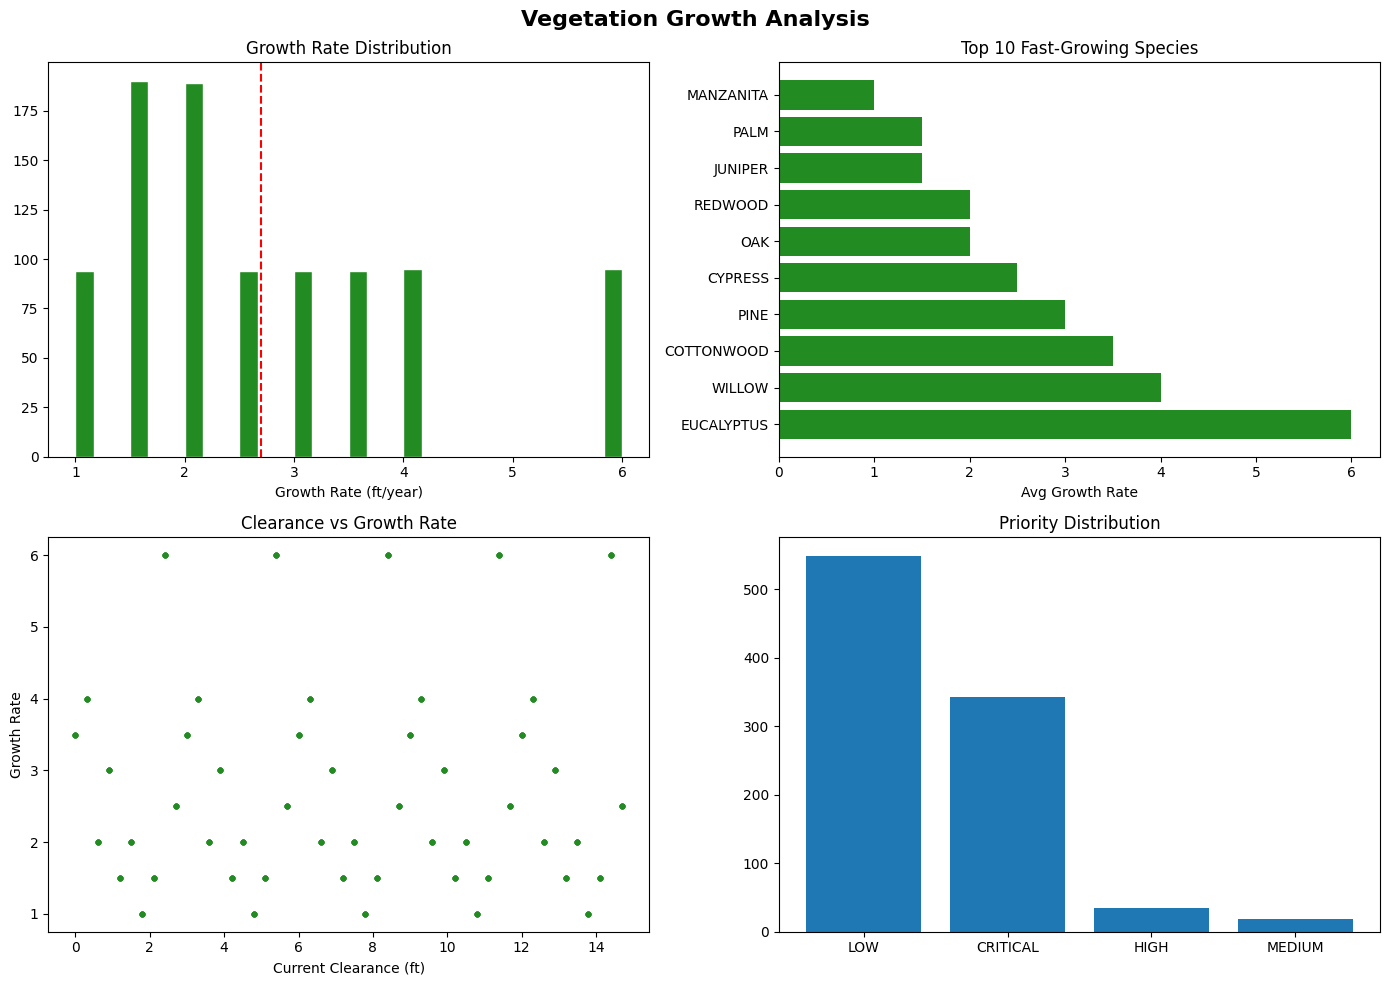

In [4]:
veg_pd = veg_df.to_pandas()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Vegetation Growth Analysis', fontsize=16, fontweight='bold')
axes[0,0].hist(veg_pd['GROWTH_RATE_FT_YEAR'], bins=30, color='forestgreen', edgecolor='white')
axes[0,0].axvline(veg_pd['GROWTH_RATE_FT_YEAR'].mean(), color='red', linestyle='--')
axes[0,0].set_xlabel('Growth Rate (ft/year)')
axes[0,0].set_title('Growth Rate Distribution')
species_growth = veg_pd.groupby('SPECIES')['GROWTH_RATE_FT_YEAR'].mean().sort_values(ascending=False).head(10)
axes[0,1].barh(species_growth.index, species_growth.values, color='forestgreen')
axes[0,1].set_xlabel('Avg Growth Rate')
axes[0,1].set_title('Top 10 Fast-Growing Species')
axes[1,0].scatter(veg_pd['CURRENT_CLEARANCE_FT'], veg_pd['GROWTH_RATE_FT_YEAR'], alpha=0.3, c='forestgreen', s=10)
axes[1,0].set_xlabel('Current Clearance (ft)')
axes[1,0].set_ylabel('Growth Rate')
axes[1,0].set_title('Clearance vs Growth Rate')
priority_counts = veg_pd['TRIM_PRIORITY'].value_counts()
axes[1,1].bar(priority_counts.index, priority_counts.values)
axes[1,1].set_title('Priority Distribution')
plt.tight_layout()
plt.show()

In [5]:
CATEGORICAL_FEATURES = ['SPECIES', 'TREE_HEALTH', 'TRIM_PRIORITY']
NUMERIC_FEATURES = ['CURRENT_CLEARANCE_FT', 'TREE_HEIGHT_FT']
TARGET = 'GROWTH_RATE_FT_YEAR'
filtered_df = veg_df.filter(col('SPECIES').is_not_null() & col('TREE_HEALTH').is_not_null() & col('TREE_HEIGHT_FT').is_not_null())
train_df, test_df = filtered_df.random_split([0.8, 0.2], seed=42)
print(f'Train: {train_df.count():,} | Test: {test_df.count():,}')

Train: 736 | Test: 209


In [6]:
encoded_cols = [f'{c}_ENC' for c in CATEGORICAL_FEATURES]
scaled_cols = [f'{c}_SCALED' for c in NUMERIC_FEATURES]
pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(input_cols=CATEGORICAL_FEATURES, output_cols=encoded_cols)),
    ('scaler', StandardScaler(input_cols=NUMERIC_FEATURES, output_cols=scaled_cols)),
    ('model', RandomForestRegressor(input_cols=encoded_cols+scaled_cols, label_cols=[TARGET], output_cols=['PREDICTED_GROWTH_RATE'], n_estimators=100, max_depth=10, random_state=42))
])
print('Training model...')
start = datetime.now()
pipeline.fit(train_df)
print(f'Training complete in {(datetime.now()-start).total_seconds():.1f}s')

Training model...


Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


The version of package 'xgboost' in the local environment is 3.1.3, which does not fit the criteria for the requirement 'xgboost==3.1.2'. Your UDF might not work when the package version is different between the server and your local environment.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:74: UserWarning: The sample input has 736 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/snowflake/ml/model/model_signature.py:74: UserWarning: The sample input has 736 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(


Training complete in 54.1s


In [7]:
predictions = pipeline.predict(test_df)
pred_pd = predictions.select('GROWTH_RATE_FT_YEAR', 'PREDICTED_GROWTH_RATE', 'SPECIES').to_pandas()
y_true = pred_pd['GROWTH_RATE_FT_YEAR']
y_pred = pred_pd['PREDICTED_GROWTH_RATE']
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print('='*50)
print('MODEL PERFORMANCE')
print('='*50)
print(f'   MAE: {mae:.3f} ft/year')
print(f'   R2: {r2:.3f}')
print('='*50)

MODEL PERFORMANCE
   MAE: 0.000 ft/year
   R2: 1.000


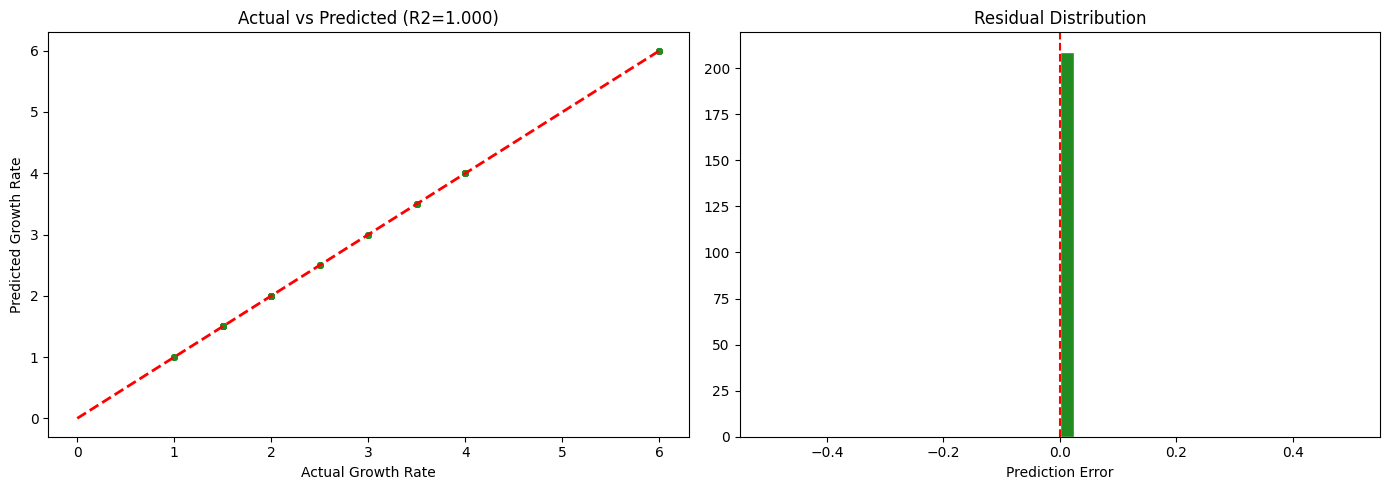

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_true, y_pred, alpha=0.3, c='forestgreen', s=15)
axes[0].plot([0, y_true.max()], [0, y_true.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Growth Rate')
axes[0].set_ylabel('Predicted Growth Rate')
axes[0].set_title(f'Actual vs Predicted (R2={r2:.3f})')
residuals = y_true - y_pred
axes[1].hist(residuals, bins=40, color='forestgreen', edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Prediction Error')
axes[1].set_title('Residual Distribution')
plt.tight_layout()
plt.show()

In [9]:
print('Generating predictions...')
all_preds = pipeline.predict(filtered_df)
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
output_df = all_preds.select(
    lit(f'VGP_{timestamp}').alias('PREDICTION_ID'),
    col('ENCROACHMENT_ID'), col('ASSET_ID'), col('SPECIES'),
    col('GROWTH_RATE_FT_YEAR').alias('ACTUAL_GROWTH_RATE'),
    col('PREDICTED_GROWTH_RATE'), col('CURRENT_CLEARANCE_FT'),
    (col('CURRENT_CLEARANCE_FT') / col('PREDICTED_GROWTH_RATE')).alias('PREDICTED_DAYS_TO_CONTACT'),
    when(col('PREDICTED_GROWTH_RATE') > 3, lit('HIGH')).when(col('PREDICTED_GROWTH_RATE') > 2, lit('MEDIUM')).otherwise(lit('LOW')).alias('GROWTH_RISK'),
    current_date().alias('PREDICTION_DATE'), lit('RANDOM_FOREST_V1').alias('MODEL_VERSION')
)
output_df.write.mode('overwrite').save_as_table('ML.VEGETATION_GROWTH_PREDICTION')
saved = output_df.count()
print(f'Saved {saved:,} predictions to ML.VEGETATION_GROWTH_PREDICTION')

Generating predictions...


Saved 945 predictions to ML.VEGETATION_GROWTH_PREDICTION


In [10]:
print('\n' + '='*60)
print('VEGETATION GROWTH PREDICTOR - SUMMARY')
print('='*60)
print(f'Data: {total_records:,} vegetation records')
print(f'Model: Random Forest (R2={r2:.3f}, MAE={mae:.3f})')
print(f'Output: ML.VEGETATION_GROWTH_PREDICTION ({saved:,} rows)')
print('='*60)


VEGETATION GROWTH PREDICTOR - SUMMARY
Data: 945 vegetation records
Model: Random Forest (R2=1.000, MAE=0.000)
Output: ML.VEGETATION_GROWTH_PREDICTION (945 rows)
